In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import ndcg_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve

In [2]:
data = pd.read_csv("data.csv")
data.head(5)

,search_term,product_variant_id,city_id,query_type,is_clicked,total_clicks,session_views,query_products_clicks_last_30_days,CTR_last_30_days,CTR_last_7_days,...,latest_margin,savings,savings_with_pass,ad_revenue,total_unique_orders,product_atcs_30_days,product_atcs_plt_30_days,total_unique_orders_plt_30_days,product_ctr_city_30_days,query_product_similarity
0,akshayakalpa milk,c442ad9b-09b6-4505-a17d-7d2b3cceee0e,ee66dc2a-aded-4445-a7b2-1ad63715725c,head,0.0,0,0,0,0.000000,0.0,...,6.900000,0.040000,2.718400,0.000000,155,376,552508,167494,0.054913,0.384844
1,ice cubes,33e1c372-8f6b-4312-b4df-93911f4c1caf,7e926d2f-adad-4e5a-956f-f07fffa54164,head,0.0,0,57,0,0.000000,0.0,...,42.010000,0.250000,5.009091,0.000000,14,41,3264,1313,0.003239,0.324977
2,protien,8ed8801e-f3bd-46ed-a212-24dcaa33d937,078d5e32-627a-4907-8df8-4360bc7c06da,head,1.0,29,545,9,0.040179,0.0,...,10.243929,0.160000,3.239500,18.622949,1469,3335,55215,24085,0.061085,0.220603
3,comb,b16224dd-5b0b-4e39-91d0-b52e563c70c2,4f30407c-6a3c-4a4e-8a3d-652217d4b6cb,head,0.0,0,13,0,0.000000,0.0,...,21.433421,0.000000,5.118421,0.000000,14567,28849,216304,121334,0.120340,0.061622
4,nail polish remover,25efac15-9a86-4da1-ab36-94e32bc7ecd9,4f30407c-6a3c-4a4e-8a3d-652217d4b6cb,tail,0.0,0,1,0,0.000000,0.0,...,13.487105,0.036957,4.915103,20.365139,1043,2446,14527,6418,0.052714,0.390254


In [3]:
# Separate features into categorical and numerical
categorical_features = data.select_dtypes(include=['object']).columns
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns

In [4]:
# Impute missing values
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')
data[categorical_features] = cat_imputer.fit_transform(data[categorical_features])
data[numerical_features] = num_imputer.fit_transform(data[numerical_features])

In [5]:
# Handle outliers using IQR method
Q1 = data[numerical_features].quantile(0.25)
Q3 = data[numerical_features].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data[numerical_features] < (Q1 - 1.5 * IQR)) | (data[numerical_features] > (Q3 + 1.5 * IQR))).any(axis=1)]

C:\Users\anshu\AppData\Local\Temp\ipykernel_20428\3926780020.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


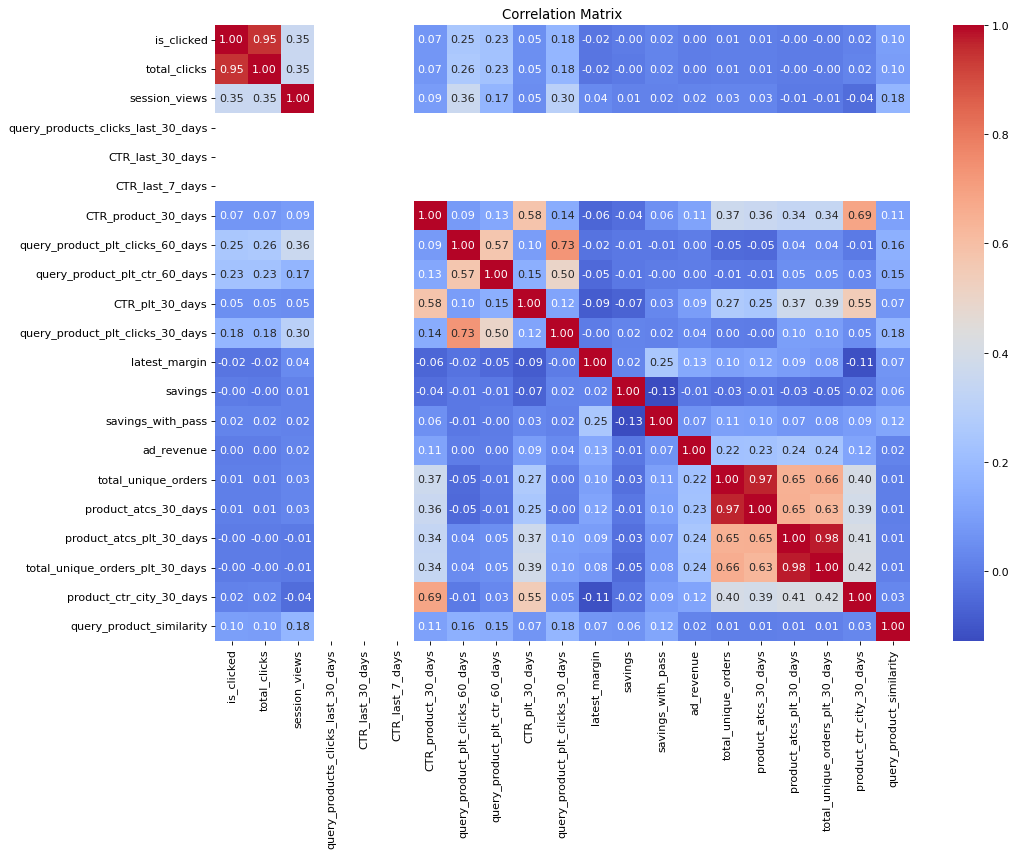

In [6]:
# Correlation matrix
corr_matrix = data.corr()
plt.figure(figsize=(14, 10), dpi=80)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

In [7]:
# Find pairs of features with correlation > 0.65
threshold = 0.65
high_corr_pairs = np.where(np.abs(corr_matrix) > threshold)
high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_pairs) if x != y and x < y]
# Print pairs of features with high correlation
print("Pairs of features with correlation > 0.65:")
for pair in high_corr_pairs:
    print(pair)

Pairs of features with correlation > 0.65:
('is_clicked', 'total_clicks')
('CTR_product_30_days', 'product_ctr_city_30_days')
('query_product_plt_clicks_60_days', 'query_product_plt_clicks_30_days')
('total_unique_orders', 'product_atcs_30_days')
('total_unique_orders', 'total_unique_orders_plt_30_days')
('product_atcs_plt_30_days', 'total_unique_orders_plt_30_days')


In [8]:
# Create interaction terms
data['average_ctr'] = (data['CTR_product_30_days'] + data['product_ctr_city_30_days']) / 2
data['order_atc_ratio'] = data['total_unique_orders'] / (data['product_atcs_30_days'] + 1e-9)
data['order_ratio'] = data['total_unique_orders'] / (data['total_unique_orders_plt_30_days'] + 1e-9)

In [9]:
# Standardize the features ( 'product_atcs_plt_30_days', 'total_unique_orders_plt_30_days' )
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['product_atcs_plt_30_days', 'total_unique_orders_plt_30_days']])

In [10]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Assuming you want 3 clusters
clusters = kmeans.fit_predict(data_scaled)
# Add the cluster labels to the original data
data['cluster'] = clusters

C:\Users\anshu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
# One-hot encode the cluster labels
encoder = OneHotEncoder(sparse=False)
cluster_encoded = encoder.fit_transform(data[['cluster']])
cluster_encoded_df = pd.DataFrame(cluster_encoded, columns=[f'cluster_{i}' for i in range(cluster_encoded.shape[1])])

C:\Users\anshu\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
# Concatenate the one-hot encoded clusters with the original data
data = pd.concat([data, cluster_encoded_df], axis=1)

# Drop the original cluster column if you no longer need it
data.drop('cluster', axis=1, inplace=True)

# Display the first few rows of the updated DataFrame
data.head()

,search_term,product_variant_id,city_id,query_type,is_clicked,total_clicks,session_views,query_products_clicks_last_30_days,CTR_last_30_days,CTR_last_7_days,...,total_unique_orders_plt_30_days,product_ctr_city_30_days,query_product_similarity,average_ctr,order_atc_ratio,order_ratio,cluster_0,cluster_1,cluster_2,cluster_3
1,ice cubes,33e1c372-8f6b-4312-b4df-93911f4c1caf,7e926d2f-adad-4e5a-956f-f07fffa54164,head,0.0,0.0,57.0,0.0,0.0,0.0,...,1313.0,0.003239,0.324977,0.003239,0.341463,0.010663,0.0,0.0,0.0,1.0
10,liquid,324dce63-fd0c-4cda-be12-1f72f4a18f6c,4f30407c-6a3c-4a4e-8a3d-652217d4b6cb,tail,0.0,0.0,5.0,0.0,0.0,0.0,...,458.0,0.004629,0.363308,0.004629,0.229282,0.181223,1.0,0.0,0.0,0.0
11,bat,efa2cfc6-651d-46b5-a995-bcdf6f46c66e,c5b3d670-f20e-4cae-a6b7-42e17b8fb08d,tail,0.0,0.0,45.0,0.0,0.0,0.0,...,287.0,0.003092,0.255233,0.003092,0.296703,0.094077,1.0,0.0,0.0,0.0
13,comb,f1a5668e-dc83-469a-b658-c68017211d2e,facade53-8330-4ebe-b07e-55319220a301,head,0.0,0.0,36.0,0.0,0.0,0.0,...,0.0,0.010663,0.187711,0.010663,0.000000,0.000000,1.0,0.0,0.0,0.0
14,ice,de01c80f-5e16-4a87-bdaa-adebfed3e891,056e834d-a1d2-4df3-a93d-7ebd60e6bb16,head,0.0,0.0,81.0,0.0,0.0,0.0,...,0.0,0.003095,0.256169,0.003095,0.000000,0.000000,0.0,0.0,0.0,1.0


In [13]:
# Print the number of unique city_id values
num_unique_cities = data['city_id'].nunique()
print(f"Number of unique city_id values: {num_unique_cities}")

# Print the number of unique product_variant_id values
num_unique_product_variant = data['product_variant_id'].nunique()
print(f"Number of unique product_variant_id values: {num_unique_product_variant}")

Number of unique city_id values: 12
Number of unique product_variant_id values: 20740


In [14]:
# Frequency Encoding function
def frequency_encoding(column):
    freq_encoding = data[column].value_counts(normalize=True)
    data[f'{column}_freq'] = data[column].map(freq_encoding)

# Apply Frequency Encoding to specific columns
columns_to_encode = ['search_term', 'predicted_category_name', 'predicted_subcategory_name', 
                     'brand_name', 'subcategory_name', 'product_name', 'city_id']
for col in columns_to_encode:
    frequency_encoding(col)

# Drop the original columns that have been frequency encoded
data.drop(columns_to_encode, axis=1, inplace=True)

In [15]:
# One-Hot Encoding for 'category_name' and 'query_type'
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(data[['category_name', 'query_type']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Combine all encoded features with the original data
data = pd.concat([data, encoded_df], axis=1)

# Drop the original columns that have been one-hot encoded
data.drop(['category_name', 'query_type'], axis=1, inplace=True)

# Drop original columns that have been encoded
data.drop(['product_variant_id'], axis=1, inplace=True)

C:\Users\anshu\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [16]:
# Check for any remaining missing values after encoding
print("Checking for missing values after encoding...")
print(data.isnull().sum())

# Impute or drop remaining NaN values
data = data.dropna()

Checking for missing values after encoding...
is_clicked                            194184
total_clicks                          194184
session_views                         194184
query_products_clicks_last_30_days    194184
CTR_last_30_days                      194184
                                       ...  
category_name_unlisted                 71258
category_name_nan                      71258
query_type_head                        71258
query_type_tail                        71258
query_type_nan                         71258
Length: 77, dtype: int64


In [17]:
# Split the data into training, development, and test sets
train_data, temp_data = train_test_split(data, test_size=0.02, random_state=42)
dev_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Separate features and target
X_train = train_data.drop('CTR_last_7_days', axis=1)
y_train = train_data['CTR_last_7_days']
X_dev = dev_data.drop('CTR_last_7_days', axis=1)
y_dev = dev_data['CTR_last_7_days']
X_test = test_data.drop('CTR_last_7_days', axis=1)
y_test = test_data['CTR_last_7_days']

# Initialize the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Train the model
dt_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [18]:
# Make predictions
y_train_pred = dt_regressor.predict(X_train)
y_dev_pred = dt_regressor.predict(X_dev)
y_test_pred = dt_regressor.predict(X_test)

In [19]:
# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
dev_rmse = np.sqrt(mean_squared_error(y_dev, y_dev_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
dev_r2 = r2_score(y_dev, y_dev_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [20]:
print(f"Training RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}")
print(f"Development RMSE: {dev_rmse:.4f}, R2: {dev_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}")

Training RMSE: 0.0000, R2: 1.0000
Development RMSE: 0.0000, R2: 1.0000
Test RMSE: 0.0000, R2: 1.0000


In [21]:
# Rank products based on predicted CTR
test_data['predicted_CTR'] = y_test_pred
ranking_columns = ['city_id_freq', 'predicted_CTR'] + list(encoded_df.columns)
test_data['rank'] = test_data[ranking_columns].rank(ascending=False).mean(axis=1)

In [22]:
# Display the ranked products
ranked_products = test_data.sort_values(by='rank')
print(ranked_products[['predicted_CTR', 'rank']])

        predicted_CTR        rank
60008             0.0  434.852273
44116             0.0  434.852273
128732            0.0  434.852273
65969             0.0  434.852273
168055            0.0  434.852273
...               ...         ...
639               0.0  453.352273
94317             0.0  453.352273
74465             0.0  453.352273
109414            0.0  453.352273
135557            0.0  453.352273

[887 rows x 2 columns]


In [23]:
test_data['rank']

145155    445.113636
118194    443.193182
199754    434.852273
163432    446.829545
87798     445.113636
             ...    
45326     451.761364
137298    453.352273
68598     453.352273
157881    450.147727
46860     451.761364
Name: rank, Length: 887, dtype: float64